In [1]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive
# !pip install -q keras
# !pip install -q pandas
# !pip install -q numpy

In [1]:
# cp ~/.config/google-chrome/Default/Cookies ~/.config/google-chrome/Default/Cookies.bak
# cp ~/.config/google-chrome/Default/Cookies ~/.config/google-chrome/Default/Cookies.bak
import os 
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, Reshape, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.recurrent import LSTM
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM
from keras.callbacks import History, ModelCheckpoint 

from iteration_utilities import flatten
from sklearn import model_selection
from __future__ import absolute_import

/home/anton/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# os.chdir("/content/drive/Hamming")
# sys.path.append("Hamming")

# import functions as f
# import model_lib 

In [3]:
tf.test.gpu_device_name()

''

# Set code params

In [4]:
# N, K_ = 31, 26
N, K_= 16, 11

In [37]:
# directory to save model, history, sub_datasets and pictures
model_directory = 'model_checkpoints_stratificate_2/'

In [6]:
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [7]:
TRAIN_PATH = './dataset_files/hamming_15_11.txt'
TEST_PATH = './dataset_files/hamming_15_11_all.txt'

COLUMN_NAMES = ['plainword', 'codeword', 
                'id_error', 'bin_error', 'defective_codeword']
types = [str, str, int, str, str]
types = dict(zip(COLUMN_NAMES, types))

# Define functions

In [8]:
def load_data(path):
    return pd.read_csv(path, sep=';', names=COLUMN_NAMES, dtype=types)

In [9]:
def hamming_distance(first: str, second: str) -> int:
    return len([1 for (x, y) in zip(first, second) if x != y])

In [10]:
def make_features():
#     data['dec_defective_codeword'] = data['defective_codeword'][:].apply(lambda x: int(x, 2))

    for j in range(len(data['codeword'][0])):
        data['cod_' + str(j)] = data['codeword'][:].apply(lambda x: int(x[j]))

    for j in range(len(data['defective_codeword'][0])):
        data['def_' + str(j)] = data['defective_codeword'][:].apply(lambda x: int(x[j]))

#     for j in range(len(data['bin_error'][0])):
#         data['mask_' + str(j)] = data['bin_error'][:].apply(lambda x: int(x[j]))
        
    data['weight'] = 1
    data.loc[data['codeword'] == data['defective_codeword'], 'weight'] = 10  ### 19
    for j in range(len(data['plainword'][0])):
        data['pln_' + str(j)] = data['plainword'][:].apply(lambda x: int(x[j]))
    
#     return data

In [11]:
def stratificate_split_data(test_size):
    N1 = N + 1
    to_test = round(N1 * test_size)  # count of lines from each "pack" 
    to_train = N1 - to_test

    train_indices = [list(range(i*N1, i*N1 + to_train)) for i in range(2**K_)]
    train_indices = list(flatten(train_indices))
    test_indices = sorted(set(range(N1 * 2**K_)) - set(train_indices))
    
    train_data = data.loc[train_indices, 'def_0':'weight']
    test_data = data.loc[test_indices, 'def_0':'weight']
    
    train_labels = data.loc[train_indices, 'cod_0':'cod_'+str(N-1)]
    test_labels = data.loc[test_indices, 'cod_0':'cod_'+str(N-1)]
    
    train_weight = train_data.pop('weight')
    test_data.drop(columns=['weight'], inplace=True)
    return np.array(train_data), np.array(test_data), \
           np.array(train_labels), np.array(test_labels), \
           np.array(train_weight)

In [12]:
def split_data(test_size): 
    train_data, test_data, train_labels, test_labels = \
        model_selection.train_test_split(data.loc[:, 'def_0':'weight'], 
                                         data.loc[:, 'cod_0':'cod_'+str(N-1)], # 'mask_0':'pln_25' 
                                         test_size = test_size) 
    
    train_weight = train_data.pop('weight')
    test_data.drop(columns=['weight'], inplace=True)
    return np.array(train_data), np.array(test_data), \
           np.array(train_labels), np.array(test_labels), \
           np.array(train_weight)

In [13]:
def logloss(y_true, y_pred): 
    return -K.log(1 - K.abs(y_true - y_pred))

In [14]:
def exploss(y_true, y_pred): 
    return K.exp(K.abs(y_true - y_pred)) - 1

In [15]:
def probs_to_labels(predicted_probs):
    return [int(x > 0.5) for x in predicted_probs]

In [16]:
def count_errors(y, y_pred):
    count = 0
    for i in range (0, N):
        labelBit = y[i]
        resultBit = y_pred[i]
        if labelBit != resultBit:
            count += 1
    return count

In [17]:
def get_error_stats(test_labels, y_pred):
    errorStats = {0: 0}
    for i in range(y_pred.shape[0]):
        resultArray = probs_to_labels(y_pred[i])
        errorNum = count_errors(test_labels[i], resultArray)
        if errorStats.get(errorNum) == None:
            errorStats[errorNum] = 0
        errorStats[errorNum] += 1
    return errorStats

In [18]:
def binary_accuracy(y, y_pred):
    return sum(1 if np.array_equal(a, probs_to_labels(b)) else 0 for (a,b) in zip(y, y_pred)) / y.shape[0]

In [35]:
def plot_history_fields(history, fields, save=False, num_dots_to_plot=-1):
    # num_dots_to_plot == -1  => plot all

    figsize_x = 20
    figsize_y = 10
    
    if 'loss' in fields:
        # summarize history for loss
        plt.figure(figsize=(figsize_x, figsize_y))
        plt.title('Функция потерь модели')
        plt.plot(history['val_loss'][:num_dots_to_plot])
        plt.plot(history['loss'][:num_dots_to_plot])
        plt.ylabel('Функция потерь')
        plt.xlabel('Номер эпохи')
        plt.legend(['Валидация', 'Обучение'], loc='upper right')
        if save:
            plt.savefig(model_directory + 'model_loss.png')
        plt.show()
        
    if 'accuracy' in fields:
        # summarize history for accuracy
        plt.figure(figsize=(figsize_x, figsize_y))
        plt.title('Точность модели')
        plt.plot(history['val_acc'][:num_dots_to_plot])
        plt.plot(history['acc'][:num_dots_to_plot])
        plt.ylabel('Точность')
        plt.xlabel('Номер эпохи')
        plt.legend(['Валидация', 'Обучение'], loc='lower right')
        if save:
            plt.savefig(model_directory + 'model_accuracy.png')
        plt.show()
        
    if 'binary_accuracy' in fields:
        # summarize history for binary accuracy
        plt.figure(figsize=(figsize_x, figsize_y))
        plt.title('Бинарная точность модели')
        plt.plot(history['val_binary_accuracy'][:num_dots_to_plot])
        plt.plot(history['binary_accuracy'][:num_dots_to_plot])
        plt.ylabel('Бинарная точность')
        plt.xlabel('Номер эпохи')
        plt.legend(['Валидация', 'Обучение'], loc='lower right')
        if save:
            plt.savefig(model_directory + 'model_binary_accuracy.png')
        plt.show()
        

In [20]:
# !git pull

# Load data and fit model

In [21]:
%%time
data = load_data(TEST_PATH)
print(data.shape)
make_features()
print(data.shape)
train_data, test_data, train_labels, test_labels, train_weight = stratificate_split_data(test_size=0.5)
# train_data, test_data, train_labels, test_labels, train_weight = split_data(test_size=0.3)
data.head()
# del(data)

(34816, 5)
(34816, 49)
CPU times: user 737 ms, sys: 30.5 ms, total: 767 ms
Wall time: 771 ms


In [22]:
# %%time
# data = load_data(TRAIN_PATH)
# # int_to_str()
# print(data.shape)
# make_features()
# print(data.shape)
# train_data, _, train_labels, _, train_weight = split_data(test_size=0.0001)

# data = load_data(TEST_PATH)
# # int_to_str()
# print(data.shape)
# make_features()
# print(data.shape)
# _, test_data, _, test_labels, _ = split_data(test_size=0.9999)
# del(data)

In [23]:
history = History()
MCP = ModelCheckpoint(model_directory + 'model_epoch:{epoch:02d}_val_loss:{val_loss:.4f}.hdf5', 
                      monitor='val_loss', 
                      verbose=0, 
                      save_best_only=True, 
                      save_weights_only=False, 
                      mode='auto', 
                      period=10
                     )

mul for N=16
* 10 - 84%
* 12 - 89%
* 13 - 92%
* 14 - 52%
* 15 - 7х%

In [24]:
mul = 13

In [25]:

# from keras import models
# from keras.utils import to_categorical
# from keras.callbacks import ModelCheckpoint

inp = Input(shape=(N,))
x = Dense(mul * N, activation='sigmoid', kernel_initializer = "glorot_uniform")(inp)
x = Dense(mul * N, activation='sigmoid', kernel_initializer = "glorot_uniform")(x)
x = Dense(mul * N, activation='sigmoid', kernel_initializer = "glorot_uniform")(x)
# x = Dense(mul * N, activation='sigmoid', kernel_initializer = "glorot_uniform")(x)
m = Dense(N, activation='sigmoid', name='d3')(x)

model = Model(inp, m, 'm')
model.compile(loss=exploss, optimizer='adam', metrics=['binary_accuracy', 'accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 208)               3536      
_________________________________________________________________
dense_2 (Dense)              (None, 208)               43472     
_________________________________________________________________
dense_3 (Dense)              (None, 208)               43472     
_________________________________________________________________
d3 (Dense)                   (None, 16)                3344      
Total params: 93,824
Trainable params: 93,824
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(x=train_data, y=train_labels, 
          validation_split=0.15,  
          shuffle=True, 
          epochs=4000, 
          batch_size=256, 
          callbacks=[history, MCP],
         )

Train on 15667 samples, validate on 2765 samples
Epoch 1/4000
15667/15667 [==============================] - 0s 24us/step - loss: 0.6479 - binary_accuracy: 0.5159 - acc: 0.0990 - val_loss: 0.6420 - val_binary_accuracy: 0.5075 - val_acc: 0.0282
Epoch 2/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.6278 - binary_accuracy: 0.6293 - acc: 0.0663 - val_loss: 0.6014 - val_binary_accuracy: 0.7425 - val_acc: 0.0235
Epoch 3/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.5397 - binary_accuracy: 0.7644 - acc: 0.0973 - val_loss: 0.4736 - val_binary_accuracy: 0.7783 - val_acc: 0.0937
Epoch 4/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.4121 - binary_accuracy: 0.8177 - acc: 0.1064 - val_loss: 0.3580 - val_binary_accuracy: 0.8566 - val_acc: 0.1089
Epoch 5/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.3087 - binary_accuracy: 0.8854 - acc: 0.1016 - val_loss: 0.2714 - val_binary_accuracy: 0

Epoch 84/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.1014 - binary_accuracy: 0.9411 - acc: 0.1203 - val_loss: 0.1021 - val_binary_accuracy: 0.9408 - val_acc: 0.1136
Epoch 85/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.1014 - binary_accuracy: 0.9411 - acc: 0.1189 - val_loss: 0.1021 - val_binary_accuracy: 0.9408 - val_acc: 0.1302
Epoch 86/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.1014 - binary_accuracy: 0.9411 - acc: 0.1207 - val_loss: 0.1020 - val_binary_accuracy: 0.9408 - val_acc: 0.1342
Epoch 87/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.1014 - binary_accuracy: 0.9411 - acc: 0.1199 - val_loss: 0.1020 - val_binary_accuracy: 0.9408 - val_acc: 0.1327
Epoch 88/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.1014 - binary_accuracy: 0.9411 - acc: 0.1210 - val_loss: 0.1020 - val_binary_accuracy: 0.9408 - val_acc: 0.1371
Epoch 89/4000
15667/

Epoch 126/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.1009 - binary_accuracy: 0.9414 - acc: 0.1184 - val_loss: 0.1019 - val_binary_accuracy: 0.9408 - val_acc: 0.0846
Epoch 127/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.1009 - binary_accuracy: 0.9414 - acc: 0.1287 - val_loss: 0.1020 - val_binary_accuracy: 0.9408 - val_acc: 0.3067
Epoch 128/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.1008 - binary_accuracy: 0.9414 - acc: 0.1358 - val_loss: 0.1020 - val_binary_accuracy: 0.9408 - val_acc: 0.1049
Epoch 129/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.1008 - binary_accuracy: 0.9414 - acc: 0.1197 - val_loss: 0.1019 - val_binary_accuracy: 0.9408 - val_acc: 0.0944
Epoch 130/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.1007 - binary_accuracy: 0.9414 - acc: 0.1084 - val_loss: 0.1019 - val_binary_accuracy: 0.9408 - val_acc: 0.1653
Epoch 131/4000


Epoch 209/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0973 - binary_accuracy: 0.9435 - acc: 0.1079 - val_loss: 0.1017 - val_binary_accuracy: 0.9408 - val_acc: 0.1031
Epoch 210/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0972 - binary_accuracy: 0.9435 - acc: 0.1218 - val_loss: 0.1018 - val_binary_accuracy: 0.9408 - val_acc: 0.0995
Epoch 211/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0972 - binary_accuracy: 0.9435 - acc: 0.1104 - val_loss: 0.1017 - val_binary_accuracy: 0.9409 - val_acc: 0.0955
Epoch 212/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0972 - binary_accuracy: 0.9435 - acc: 0.1056 - val_loss: 0.1017 - val_binary_accuracy: 0.9409 - val_acc: 0.1356
Epoch 213/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0971 - binary_accuracy: 0.9435 - acc: 0.1185 - val_loss: 0.1017 - val_binary_accuracy: 0.9408 - val_acc: 0.1844
Epoch 214/4000


Epoch 292/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0930 - binary_accuracy: 0.9460 - acc: 0.2251 - val_loss: 0.1010 - val_binary_accuracy: 0.9413 - val_acc: 0.3371
Epoch 293/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0930 - binary_accuracy: 0.9460 - acc: 0.2602 - val_loss: 0.1008 - val_binary_accuracy: 0.9413 - val_acc: 0.2391
Epoch 294/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0929 - binary_accuracy: 0.9461 - acc: 0.2544 - val_loss: 0.1008 - val_binary_accuracy: 0.9414 - val_acc: 0.2166
Epoch 295/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0928 - binary_accuracy: 0.9461 - acc: 0.2398 - val_loss: 0.1008 - val_binary_accuracy: 0.9413 - val_acc: 0.2257
Epoch 296/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0928 - binary_accuracy: 0.9461 - acc: 0.2535 - val_loss: 0.1007 - val_binary_accuracy: 0.9414 - val_acc: 0.2354
Epoch 297/4000


Epoch 375/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0821 - binary_accuracy: 0.9525 - acc: 0.2944 - val_loss: 0.0955 - val_binary_accuracy: 0.9446 - val_acc: 0.2926
Epoch 376/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0819 - binary_accuracy: 0.9526 - acc: 0.2893 - val_loss: 0.0955 - val_binary_accuracy: 0.9445 - val_acc: 0.2749
Epoch 377/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0817 - binary_accuracy: 0.9528 - acc: 0.2867 - val_loss: 0.0952 - val_binary_accuracy: 0.9448 - val_acc: 0.2937
Epoch 378/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0815 - binary_accuracy: 0.9529 - acc: 0.2921 - val_loss: 0.0952 - val_binary_accuracy: 0.9446 - val_acc: 0.2850
Epoch 379/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0813 - binary_accuracy: 0.9531 - acc: 0.2836 - val_loss: 0.0951 - val_binary_accuracy: 0.9446 - val_acc: 0.2550
Epoch 380/4000


Epoch 458/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0596 - binary_accuracy: 0.9659 - acc: 0.2346 - val_loss: 0.0771 - val_binary_accuracy: 0.9554 - val_acc: 0.2033
Epoch 459/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0594 - binary_accuracy: 0.9661 - acc: 0.2364 - val_loss: 0.0767 - val_binary_accuracy: 0.9556 - val_acc: 0.2040
Epoch 460/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0591 - binary_accuracy: 0.9662 - acc: 0.2358 - val_loss: 0.0766 - val_binary_accuracy: 0.9557 - val_acc: 0.2007
Epoch 461/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0589 - binary_accuracy: 0.9664 - acc: 0.2263 - val_loss: 0.0766 - val_binary_accuracy: 0.9556 - val_acc: 0.1982
Epoch 462/4000
15667/15667 [==============================] - 0s 17us/step - loss: 0.0587 - binary_accuracy: 0.9665 - acc: 0.2370 - val_loss: 0.0762 - val_binary_accuracy: 0.9560 - val_acc: 0.2094
Epoch 463/4000


Epoch 541/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0469 - binary_accuracy: 0.9732 - acc: 0.3168 - val_loss: 0.0653 - val_binary_accuracy: 0.9624 - val_acc: 0.2984
Epoch 542/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0468 - binary_accuracy: 0.9732 - acc: 0.3186 - val_loss: 0.0652 - val_binary_accuracy: 0.9623 - val_acc: 0.2879
Epoch 543/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0466 - binary_accuracy: 0.9733 - acc: 0.3094 - val_loss: 0.0648 - val_binary_accuracy: 0.9627 - val_acc: 0.2948
Epoch 544/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0465 - binary_accuracy: 0.9734 - acc: 0.3153 - val_loss: 0.0647 - val_binary_accuracy: 0.9629 - val_acc: 0.2803
Epoch 545/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0465 - binary_accuracy: 0.9734 - acc: 0.3211 - val_loss: 0.0650 - val_binary_accuracy: 0.9625 - val_acc: 0.2944
Epoch 546/4000


Epoch 624/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0422 - binary_accuracy: 0.9756 - acc: 0.4079 - val_loss: 0.0606 - val_binary_accuracy: 0.9648 - val_acc: 0.3754
Epoch 625/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0421 - binary_accuracy: 0.9756 - acc: 0.4058 - val_loss: 0.0608 - val_binary_accuracy: 0.9648 - val_acc: 0.3580
Epoch 626/4000
15667/15667 [==============================] - 0s 17us/step - loss: 0.0421 - binary_accuracy: 0.9756 - acc: 0.4070 - val_loss: 0.0609 - val_binary_accuracy: 0.9646 - val_acc: 0.3848
Epoch 627/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0421 - binary_accuracy: 0.9757 - acc: 0.4137 - val_loss: 0.0610 - val_binary_accuracy: 0.9646 - val_acc: 0.4029
Epoch 628/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0421 - binary_accuracy: 0.9757 - acc: 0.4159 - val_loss: 0.0605 - val_binary_accuracy: 0.9649 - val_acc: 0.3826
Epoch 629/4000


Epoch 707/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0399 - binary_accuracy: 0.9768 - acc: 0.5134 - val_loss: 0.0577 - val_binary_accuracy: 0.9665 - val_acc: 0.4456
Epoch 708/4000
15667/15667 [==============================] - 0s 17us/step - loss: 0.0399 - binary_accuracy: 0.9768 - acc: 0.5180 - val_loss: 0.0573 - val_binary_accuracy: 0.9669 - val_acc: 0.4835
Epoch 709/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0399 - binary_accuracy: 0.9769 - acc: 0.5168 - val_loss: 0.0574 - val_binary_accuracy: 0.9666 - val_acc: 0.4759
Epoch 710/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0399 - binary_accuracy: 0.9769 - acc: 0.5151 - val_loss: 0.0574 - val_binary_accuracy: 0.9665 - val_acc: 0.4767
Epoch 711/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0398 - binary_accuracy: 0.9769 - acc: 0.5173 - val_loss: 0.0574 - val_binary_accuracy: 0.9668 - val_acc: 0.4759
Epoch 712/4000


Epoch 790/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0388 - binary_accuracy: 0.9775 - acc: 0.5823 - val_loss: 0.0567 - val_binary_accuracy: 0.9670 - val_acc: 0.5982
Epoch 791/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0388 - binary_accuracy: 0.9775 - acc: 0.5791 - val_loss: 0.0567 - val_binary_accuracy: 0.9671 - val_acc: 0.5750
Epoch 792/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0387 - binary_accuracy: 0.9775 - acc: 0.5735 - val_loss: 0.0565 - val_binary_accuracy: 0.9671 - val_acc: 0.5642
Epoch 793/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0387 - binary_accuracy: 0.9775 - acc: 0.5836 - val_loss: 0.0566 - val_binary_accuracy: 0.9670 - val_acc: 0.5591
Epoch 794/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0387 - binary_accuracy: 0.9775 - acc: 0.5833 - val_loss: 0.0569 - val_binary_accuracy: 0.9669 - val_acc: 0.5649
Epoch 795/4000


Epoch 873/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0381 - binary_accuracy: 0.9779 - acc: 0.5988 - val_loss: 0.0564 - val_binary_accuracy: 0.9672 - val_acc: 0.5772
Epoch 874/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0380 - binary_accuracy: 0.9780 - acc: 0.6043 - val_loss: 0.0564 - val_binary_accuracy: 0.9672 - val_acc: 0.5732
Epoch 875/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0379 - binary_accuracy: 0.9780 - acc: 0.5993 - val_loss: 0.0560 - val_binary_accuracy: 0.9674 - val_acc: 0.5946
Epoch 876/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0379 - binary_accuracy: 0.9780 - acc: 0.6117 - val_loss: 0.0561 - val_binary_accuracy: 0.9673 - val_acc: 0.5964
Epoch 877/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0379 - binary_accuracy: 0.9780 - acc: 0.6111 - val_loss: 0.0562 - val_binary_accuracy: 0.9675 - val_acc: 0.5627
Epoch 878/4000


Epoch 956/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0362 - binary_accuracy: 0.9789 - acc: 0.6392 - val_loss: 0.0546 - val_binary_accuracy: 0.9682 - val_acc: 0.6058
Epoch 957/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0362 - binary_accuracy: 0.9789 - acc: 0.6359 - val_loss: 0.0545 - val_binary_accuracy: 0.9681 - val_acc: 0.6014
Epoch 958/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0362 - binary_accuracy: 0.9789 - acc: 0.6399 - val_loss: 0.0545 - val_binary_accuracy: 0.9681 - val_acc: 0.6083
Epoch 959/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0362 - binary_accuracy: 0.9790 - acc: 0.6428 - val_loss: 0.0543 - val_binary_accuracy: 0.9682 - val_acc: 0.6101
Epoch 960/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0362 - binary_accuracy: 0.9790 - acc: 0.6445 - val_loss: 0.0543 - val_binary_accuracy: 0.9684 - val_acc: 0.6188
Epoch 961/4000


15667/15667 [==============================] - 0s 16us/step - loss: 0.0348 - binary_accuracy: 0.9797 - acc: 0.6732 - val_loss: 0.0533 - val_binary_accuracy: 0.9690 - val_acc: 0.6459
Epoch 1039/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0348 - binary_accuracy: 0.9797 - acc: 0.6758 - val_loss: 0.0532 - val_binary_accuracy: 0.9691 - val_acc: 0.6412
Epoch 1040/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0348 - binary_accuracy: 0.9797 - acc: 0.6772 - val_loss: 0.0532 - val_binary_accuracy: 0.9691 - val_acc: 0.6441
Epoch 1041/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0348 - binary_accuracy: 0.9797 - acc: 0.6769 - val_loss: 0.0532 - val_binary_accuracy: 0.9691 - val_acc: 0.6514
Epoch 1042/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0348 - binary_accuracy: 0.9797 - acc: 0.6791 - val_loss: 0.0532 - val_binary_accuracy: 0.9691 - val_acc: 0.6438
Epoch 1043/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0346 - binary_accuracy: 0.9799 - acc: 0.6679 - val_loss: 0.0536 - val_binary_accuracy: 0.9688 - val_acc: 0.6553
Epoch 1121/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0346 - binary_accuracy: 0.9799 - acc: 0.6758 - val_loss: 0.0534 - val_binary_accuracy: 0.9688 - val_acc: 0.6485
Epoch 1122/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0346 - binary_accuracy: 0.9799 - acc: 0.6778 - val_loss: 0.0533 - val_binary_accuracy: 0.9688 - val_acc: 0.6528
Epoch 1123/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0346 - binary_accuracy: 0.9799 - acc: 0.6819 - val_loss: 0.0532 - val_binary_accuracy: 0.9689 - val_acc: 0.6492
Epoch 1124/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0346 - binary_accuracy: 0.9799 - acc: 0.6780 - val_loss: 0.0532 - val_binary_accuracy: 0.9689 - val_acc: 0.6481
Epoch 1125/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0344 - binary_accuracy: 0.9800 - acc: 0.7080 - val_loss: 0.0530 - val_binary_accuracy: 0.9690 - val_acc: 0.6832
Epoch 1203/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0344 - binary_accuracy: 0.9800 - acc: 0.7096 - val_loss: 0.0530 - val_binary_accuracy: 0.9690 - val_acc: 0.6821
Epoch 1204/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0344 - binary_accuracy: 0.9800 - acc: 0.7087 - val_loss: 0.0530 - val_binary_accuracy: 0.9690 - val_acc: 0.6839
Epoch 1205/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0344 - binary_accuracy: 0.9800 - acc: 0.7096 - val_loss: 0.0530 - val_binary_accuracy: 0.9690 - val_acc: 0.6832
Epoch 1206/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0344 - binary_accuracy: 0.9800 - acc: 0.7096 - val_loss: 0.0530 - val_binary_accuracy: 0.9690 - val_acc: 0.6854
Epoch 1207/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0344 - binary_accuracy: 0.9800 - acc: 0.7162 - val_loss: 0.0532 - val_binary_accuracy: 0.9689 - val_acc: 0.7045
Epoch 1285/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0343 - binary_accuracy: 0.9800 - acc: 0.7196 - val_loss: 0.0531 - val_binary_accuracy: 0.9689 - val_acc: 0.6908
Epoch 1286/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0343 - binary_accuracy: 0.9800 - acc: 0.7193 - val_loss: 0.0530 - val_binary_accuracy: 0.9690 - val_acc: 0.7045
Epoch 1287/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0343 - binary_accuracy: 0.9801 - acc: 0.7245 - val_loss: 0.0528 - val_binary_accuracy: 0.9691 - val_acc: 0.6951
Epoch 1288/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0343 - binary_accuracy: 0.9801 - acc: 0.7193 - val_loss: 0.0528 - val_binary_accuracy: 0.9692 - val_acc: 0.6893
Epoch 1289/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0342 - binary_accuracy: 0.9801 - acc: 0.7306 - val_loss: 0.0525 - val_binary_accuracy: 0.9693 - val_acc: 0.7096
Epoch 1367/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0344 - binary_accuracy: 0.9800 - acc: 0.7347 - val_loss: 0.0546 - val_binary_accuracy: 0.9683 - val_acc: 0.7255
Epoch 1368/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0349 - binary_accuracy: 0.9798 - acc: 0.7325 - val_loss: 0.0546 - val_binary_accuracy: 0.9680 - val_acc: 0.6752
Epoch 1369/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0344 - binary_accuracy: 0.9801 - acc: 0.7200 - val_loss: 0.0538 - val_binary_accuracy: 0.9685 - val_acc: 0.6821
Epoch 1370/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0342 - binary_accuracy: 0.9801 - acc: 0.7120 - val_loss: 0.0532 - val_binary_accuracy: 0.9689 - val_acc: 0.6966
Epoch 1371/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0339 - binary_accuracy: 0.9803 - acc: 0.7190 - val_loss: 0.0526 - val_binary_accuracy: 0.9694 - val_acc: 0.6897
Epoch 1449/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0339 - binary_accuracy: 0.9803 - acc: 0.7213 - val_loss: 0.0524 - val_binary_accuracy: 0.9695 - val_acc: 0.6901
Epoch 1450/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0339 - binary_accuracy: 0.9803 - acc: 0.7228 - val_loss: 0.0524 - val_binary_accuracy: 0.9694 - val_acc: 0.6922
Epoch 1451/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0339 - binary_accuracy: 0.9803 - acc: 0.7255 - val_loss: 0.0527 - val_binary_accuracy: 0.9691 - val_acc: 0.6929
Epoch 1452/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0339 - binary_accuracy: 0.9803 - acc: 0.7285 - val_loss: 0.0525 - val_binary_accuracy: 0.9693 - val_acc: 0.6915
Epoch 1453/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0336 - binary_accuracy: 0.9805 - acc: 0.7396 - val_loss: 0.0523 - val_binary_accuracy: 0.9694 - val_acc: 0.7042
Epoch 1531/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0335 - binary_accuracy: 0.9805 - acc: 0.7301 - val_loss: 0.0521 - val_binary_accuracy: 0.9696 - val_acc: 0.7002
Epoch 1532/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0336 - binary_accuracy: 0.9805 - acc: 0.7326 - val_loss: 0.0528 - val_binary_accuracy: 0.9690 - val_acc: 0.7425
Epoch 1533/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0336 - binary_accuracy: 0.9805 - acc: 0.7223 - val_loss: 0.0531 - val_binary_accuracy: 0.9688 - val_acc: 0.6915
Epoch 1534/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0336 - binary_accuracy: 0.9805 - acc: 0.7268 - val_loss: 0.0528 - val_binary_accuracy: 0.9692 - val_acc: 0.7056
Epoch 1535/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0333 - binary_accuracy: 0.9806 - acc: 0.7361 - val_loss: 0.0520 - val_binary_accuracy: 0.9696 - val_acc: 0.7103
Epoch 1613/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0333 - binary_accuracy: 0.9806 - acc: 0.7360 - val_loss: 0.0519 - val_binary_accuracy: 0.9696 - val_acc: 0.7103
Epoch 1614/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0333 - binary_accuracy: 0.9806 - acc: 0.7371 - val_loss: 0.0519 - val_binary_accuracy: 0.9696 - val_acc: 0.7118
Epoch 1615/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0333 - binary_accuracy: 0.9806 - acc: 0.7377 - val_loss: 0.0519 - val_binary_accuracy: 0.9696 - val_acc: 0.7128
Epoch 1616/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0333 - binary_accuracy: 0.9806 - acc: 0.7377 - val_loss: 0.0519 - val_binary_accuracy: 0.9696 - val_acc: 0.7146
Epoch 1617/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0332 - binary_accuracy: 0.9807 - acc: 0.7423 - val_loss: 0.0520 - val_binary_accuracy: 0.9697 - val_acc: 0.7157
Epoch 1695/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0332 - binary_accuracy: 0.9807 - acc: 0.7433 - val_loss: 0.0520 - val_binary_accuracy: 0.9697 - val_acc: 0.7161
Epoch 1696/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0332 - binary_accuracy: 0.9807 - acc: 0.7433 - val_loss: 0.0520 - val_binary_accuracy: 0.9697 - val_acc: 0.7161
Epoch 1697/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0332 - binary_accuracy: 0.9807 - acc: 0.7444 - val_loss: 0.0520 - val_binary_accuracy: 0.9697 - val_acc: 0.7154
Epoch 1698/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0332 - binary_accuracy: 0.9807 - acc: 0.7447 - val_loss: 0.0520 - val_binary_accuracy: 0.9697 - val_acc: 0.7161
Epoch 1699/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0331 - binary_accuracy: 0.9807 - acc: 0.7855 - val_loss: 0.0518 - val_binary_accuracy: 0.9696 - val_acc: 0.7675
Epoch 1777/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0331 - binary_accuracy: 0.9807 - acc: 0.7866 - val_loss: 0.0518 - val_binary_accuracy: 0.9697 - val_acc: 0.7675
Epoch 1778/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0331 - binary_accuracy: 0.9807 - acc: 0.7866 - val_loss: 0.0518 - val_binary_accuracy: 0.9696 - val_acc: 0.7671
Epoch 1779/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0331 - binary_accuracy: 0.9807 - acc: 0.7866 - val_loss: 0.0518 - val_binary_accuracy: 0.9696 - val_acc: 0.7685
Epoch 1780/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0331 - binary_accuracy: 0.9807 - acc: 0.7864 - val_loss: 0.0518 - val_binary_accuracy: 0.9696 - val_acc: 0.7696
Epoch 1781/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7670 - val_loss: 0.0519 - val_binary_accuracy: 0.9698 - val_acc: 0.7371
Epoch 1859/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7671 - val_loss: 0.0519 - val_binary_accuracy: 0.9697 - val_acc: 0.7374
Epoch 1860/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7694 - val_loss: 0.0519 - val_binary_accuracy: 0.9697 - val_acc: 0.7389
Epoch 1861/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7693 - val_loss: 0.0519 - val_binary_accuracy: 0.9698 - val_acc: 0.7389
Epoch 1862/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7737 - val_loss: 0.0519 - val_binary_accuracy: 0.9697 - val_acc: 0.7461
Epoch 1863/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7894 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7613
Epoch 1941/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7880 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7613
Epoch 1942/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7892 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7620
Epoch 1943/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7899 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7620
Epoch 1944/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7911 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7635
Epoch 1945/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0329 - binary_accuracy: 0.9808 - acc: 0.7942 - val_loss: 0.0527 - val_binary_accuracy: 0.9691 - val_acc: 0.7711
Epoch 2023/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0329 - binary_accuracy: 0.9808 - acc: 0.7946 - val_loss: 0.0524 - val_binary_accuracy: 0.9695 - val_acc: 0.7707
Epoch 2024/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0329 - binary_accuracy: 0.9808 - acc: 0.7949 - val_loss: 0.0523 - val_binary_accuracy: 0.9695 - val_acc: 0.7703
Epoch 2025/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0329 - binary_accuracy: 0.9808 - acc: 0.7949 - val_loss: 0.0523 - val_binary_accuracy: 0.9695 - val_acc: 0.7707
Epoch 2026/4000
15667/15667 [==============================] - 0s 14us/step - loss: 0.0329 - binary_accuracy: 0.9808 - acc: 0.7949 - val_loss: 0.0522 - val_binary_accuracy: 0.9695 - val_acc: 0.7700
Epoch 2027/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0330 - binary_accuracy: 0.9808 - acc: 0.7855 - val_loss: 0.0530 - val_binary_accuracy: 0.9689 - val_acc: 0.7595
Epoch 2105/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0329 - binary_accuracy: 0.9809 - acc: 0.7892 - val_loss: 0.0527 - val_binary_accuracy: 0.9690 - val_acc: 0.7631
Epoch 2106/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0329 - binary_accuracy: 0.9809 - acc: 0.7905 - val_loss: 0.0524 - val_binary_accuracy: 0.9692 - val_acc: 0.7577
Epoch 2107/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0329 - binary_accuracy: 0.9809 - acc: 0.7892 - val_loss: 0.0524 - val_binary_accuracy: 0.9692 - val_acc: 0.7580
Epoch 2108/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0329 - binary_accuracy: 0.9809 - acc: 0.7887 - val_loss: 0.0523 - val_binary_accuracy: 0.9692 - val_acc: 0.7584
Epoch 2109/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0328 - binary_accuracy: 0.9809 - acc: 0.7913 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7664
Epoch 2187/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0328 - binary_accuracy: 0.9809 - acc: 0.7892 - val_loss: 0.0516 - val_binary_accuracy: 0.9698 - val_acc: 0.7664
Epoch 2188/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0328 - binary_accuracy: 0.9809 - acc: 0.7901 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7664
Epoch 2189/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0328 - binary_accuracy: 0.9809 - acc: 0.7903 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7675
Epoch 2190/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0328 - binary_accuracy: 0.9809 - acc: 0.7906 - val_loss: 0.0516 - val_binary_accuracy: 0.9699 - val_acc: 0.7682
Epoch 2191/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0327 - binary_accuracy: 0.9810 - acc: 0.7966 - val_loss: 0.0514 - val_binary_accuracy: 0.9698 - val_acc: 0.7642
Epoch 2269/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0327 - binary_accuracy: 0.9810 - acc: 0.7963 - val_loss: 0.0514 - val_binary_accuracy: 0.9698 - val_acc: 0.7646
Epoch 2270/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0327 - binary_accuracy: 0.9810 - acc: 0.7966 - val_loss: 0.0514 - val_binary_accuracy: 0.9698 - val_acc: 0.7646
Epoch 2271/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0327 - binary_accuracy: 0.9810 - acc: 0.7969 - val_loss: 0.0514 - val_binary_accuracy: 0.9698 - val_acc: 0.7649
Epoch 2272/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0327 - binary_accuracy: 0.9810 - acc: 0.7969 - val_loss: 0.0513 - val_binary_accuracy: 0.9698 - val_acc: 0.7649
Epoch 2273/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0326 - binary_accuracy: 0.9810 - acc: 0.7993 - val_loss: 0.0516 - val_binary_accuracy: 0.9698 - val_acc: 0.7718
Epoch 2351/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0326 - binary_accuracy: 0.9810 - acc: 0.7995 - val_loss: 0.0516 - val_binary_accuracy: 0.9698 - val_acc: 0.7714
Epoch 2352/4000
15667/15667 [==============================] - 0s 17us/step - loss: 0.0326 - binary_accuracy: 0.9810 - acc: 0.7997 - val_loss: 0.0516 - val_binary_accuracy: 0.9698 - val_acc: 0.7722
Epoch 2353/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0326 - binary_accuracy: 0.9810 - acc: 0.7996 - val_loss: 0.0516 - val_binary_accuracy: 0.9698 - val_acc: 0.7725
Epoch 2354/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0326 - binary_accuracy: 0.9810 - acc: 0.8002 - val_loss: 0.0516 - val_binary_accuracy: 0.9698 - val_acc: 0.7729
Epoch 2355/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9811 - acc: 0.7961 - val_loss: 0.0510 - val_binary_accuracy: 0.9703 - val_acc: 0.7682
Epoch 2433/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9811 - acc: 0.7959 - val_loss: 0.0510 - val_binary_accuracy: 0.9703 - val_acc: 0.7678
Epoch 2434/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9811 - acc: 0.7965 - val_loss: 0.0509 - val_binary_accuracy: 0.9703 - val_acc: 0.7682
Epoch 2435/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9811 - acc: 0.7963 - val_loss: 0.0509 - val_binary_accuracy: 0.9703 - val_acc: 0.7689
Epoch 2436/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9811 - acc: 0.7969 - val_loss: 0.0509 - val_binary_accuracy: 0.9703 - val_acc: 0.7693
Epoch 2437/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0324 - binary_accuracy: 0.9812 - acc: 0.8040 - val_loss: 0.0510 - val_binary_accuracy: 0.9702 - val_acc: 0.7754
Epoch 2515/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9812 - acc: 0.8044 - val_loss: 0.0510 - val_binary_accuracy: 0.9702 - val_acc: 0.7761
Epoch 2516/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9812 - acc: 0.8053 - val_loss: 0.0510 - val_binary_accuracy: 0.9702 - val_acc: 0.7765
Epoch 2517/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0324 - binary_accuracy: 0.9812 - acc: 0.8053 - val_loss: 0.0510 - val_binary_accuracy: 0.9702 - val_acc: 0.7783
Epoch 2518/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0324 - binary_accuracy: 0.9812 - acc: 0.8060 - val_loss: 0.0510 - val_binary_accuracy: 0.9702 - val_acc: 0.7783
Epoch 2519/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.8019 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7696
Epoch 2597/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.8024 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7700
Epoch 2598/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.8023 - val_loss: 0.0511 - val_binary_accuracy: 0.9702 - val_acc: 0.7696
Epoch 2599/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.8025 - val_loss: 0.0511 - val_binary_accuracy: 0.9702 - val_acc: 0.7711
Epoch 2600/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.8030 - val_loss: 0.0510 - val_binary_accuracy: 0.9702 - val_acc: 0.7729
Epoch 2601/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.7877 - val_loss: 0.0515 - val_binary_accuracy: 0.9698 - val_acc: 0.7544
Epoch 2679/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.7894 - val_loss: 0.0515 - val_binary_accuracy: 0.9699 - val_acc: 0.7570
Epoch 2680/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.7901 - val_loss: 0.0514 - val_binary_accuracy: 0.9700 - val_acc: 0.7573
Epoch 2681/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.7922 - val_loss: 0.0514 - val_binary_accuracy: 0.9700 - val_acc: 0.7580
Epoch 2682/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.7931 - val_loss: 0.0513 - val_binary_accuracy: 0.9700 - val_acc: 0.7591
Epoch 2683/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.7987 - val_loss: 0.0507 - val_binary_accuracy: 0.9703 - val_acc: 0.7675
Epoch 2761/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.7996 - val_loss: 0.0507 - val_binary_accuracy: 0.9703 - val_acc: 0.7678
Epoch 2762/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.7986 - val_loss: 0.0507 - val_binary_accuracy: 0.9703 - val_acc: 0.7682
Epoch 2763/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.7994 - val_loss: 0.0507 - val_binary_accuracy: 0.9704 - val_acc: 0.7685
Epoch 2764/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.8000 - val_loss: 0.0507 - val_binary_accuracy: 0.9704 - val_acc: 0.7682
Epoch 2765/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.8121 - val_loss: 0.0508 - val_binary_accuracy: 0.9703 - val_acc: 0.7834
Epoch 2843/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.8130 - val_loss: 0.0508 - val_binary_accuracy: 0.9703 - val_acc: 0.7837
Epoch 2844/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.8130 - val_loss: 0.0508 - val_binary_accuracy: 0.9703 - val_acc: 0.7848
Epoch 2845/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.8134 - val_loss: 0.0508 - val_binary_accuracy: 0.9703 - val_acc: 0.7841
Epoch 2846/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0322 - binary_accuracy: 0.9813 - acc: 0.8137 - val_loss: 0.0508 - val_binary_accuracy: 0.9703 - val_acc: 0.7844
Epoch 2847/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0321 - binary_accuracy: 0.9813 - acc: 0.8252 - val_loss: 0.0506 - val_binary_accuracy: 0.9704 - val_acc: 0.7953
Epoch 2925/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0321 - binary_accuracy: 0.9813 - acc: 0.8250 - val_loss: 0.0506 - val_binary_accuracy: 0.9704 - val_acc: 0.7953
Epoch 2926/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0321 - binary_accuracy: 0.9813 - acc: 0.8256 - val_loss: 0.0506 - val_binary_accuracy: 0.9704 - val_acc: 0.7953
Epoch 2927/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0321 - binary_accuracy: 0.9813 - acc: 0.8252 - val_loss: 0.0506 - val_binary_accuracy: 0.9704 - val_acc: 0.7953
Epoch 2928/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0321 - binary_accuracy: 0.9813 - acc: 0.8257 - val_loss: 0.0506 - val_binary_accuracy: 0.9704 - val_acc: 0.7960
Epoch 2929/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0320 - binary_accuracy: 0.9814 - acc: 0.8044 - val_loss: 0.0513 - val_binary_accuracy: 0.9699 - val_acc: 0.7714
Epoch 3007/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0320 - binary_accuracy: 0.9814 - acc: 0.8051 - val_loss: 0.0513 - val_binary_accuracy: 0.9700 - val_acc: 0.7718
Epoch 3008/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0320 - binary_accuracy: 0.9814 - acc: 0.8060 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7729
Epoch 3009/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0320 - binary_accuracy: 0.9814 - acc: 0.8070 - val_loss: 0.0512 - val_binary_accuracy: 0.9701 - val_acc: 0.7732
Epoch 3010/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0320 - binary_accuracy: 0.9814 - acc: 0.8077 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7736
Epoch 3011/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0319 - binary_accuracy: 0.9814 - acc: 0.8097 - val_loss: 0.0510 - val_binary_accuracy: 0.9702 - val_acc: 0.7747
Epoch 3089/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0319 - binary_accuracy: 0.9814 - acc: 0.8106 - val_loss: 0.0509 - val_binary_accuracy: 0.9702 - val_acc: 0.7765
Epoch 3090/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0319 - binary_accuracy: 0.9814 - acc: 0.8118 - val_loss: 0.0517 - val_binary_accuracy: 0.9697 - val_acc: 0.7812
Epoch 3091/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0321 - binary_accuracy: 0.9813 - acc: 0.7968 - val_loss: 0.0534 - val_binary_accuracy: 0.9689 - val_acc: 0.7902
Epoch 3092/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0323 - binary_accuracy: 0.9812 - acc: 0.8090 - val_loss: 0.0546 - val_binary_accuracy: 0.9680 - val_acc: 0.7975
Epoch 3093/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0317 - binary_accuracy: 0.9816 - acc: 0.8129 - val_loss: 0.0510 - val_binary_accuracy: 0.9703 - val_acc: 0.7754
Epoch 3171/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0318 - binary_accuracy: 0.9815 - acc: 0.8121 - val_loss: 0.0528 - val_binary_accuracy: 0.9693 - val_acc: 0.7472
Epoch 3172/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0319 - binary_accuracy: 0.9815 - acc: 0.8077 - val_loss: 0.0523 - val_binary_accuracy: 0.9693 - val_acc: 0.7664
Epoch 3173/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0317 - binary_accuracy: 0.9816 - acc: 0.7990 - val_loss: 0.0518 - val_binary_accuracy: 0.9697 - val_acc: 0.7675
Epoch 3174/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0317 - binary_accuracy: 0.9815 - acc: 0.8051 - val_loss: 0.0520 - val_binary_accuracy: 0.9695 - val_acc: 0.7834
Epoch 3175/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0313 - binary_accuracy: 0.9818 - acc: 0.8072 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7700
Epoch 3253/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0313 - binary_accuracy: 0.9818 - acc: 0.8147 - val_loss: 0.0514 - val_binary_accuracy: 0.9699 - val_acc: 0.7783
Epoch 3254/4000
15667/15667 [==============================] - 0s 17us/step - loss: 0.0313 - binary_accuracy: 0.9818 - acc: 0.8114 - val_loss: 0.0514 - val_binary_accuracy: 0.9699 - val_acc: 0.7725
Epoch 3255/4000
15667/15667 [==============================] - 0s 14us/step - loss: 0.0313 - binary_accuracy: 0.9818 - acc: 0.8097 - val_loss: 0.0513 - val_binary_accuracy: 0.9699 - val_acc: 0.7732
Epoch 3256/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0313 - binary_accuracy: 0.9818 - acc: 0.8094 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7736
Epoch 3257/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0311 - binary_accuracy: 0.9819 - acc: 0.8155 - val_loss: 0.0512 - val_binary_accuracy: 0.9699 - val_acc: 0.7826
Epoch 3335/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0311 - binary_accuracy: 0.9819 - acc: 0.8153 - val_loss: 0.0512 - val_binary_accuracy: 0.9699 - val_acc: 0.7823
Epoch 3336/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0311 - binary_accuracy: 0.9819 - acc: 0.8158 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7826
Epoch 3337/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0311 - binary_accuracy: 0.9819 - acc: 0.8155 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7823
Epoch 3338/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0311 - binary_accuracy: 0.9819 - acc: 0.8163 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7830
Epoch 3339/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0310 - binary_accuracy: 0.9819 - acc: 0.8186 - val_loss: 0.0512 - val_binary_accuracy: 0.9701 - val_acc: 0.7924
Epoch 3417/4000
15667/15667 [==============================] - 0s 17us/step - loss: 0.0310 - binary_accuracy: 0.9819 - acc: 0.8188 - val_loss: 0.0512 - val_binary_accuracy: 0.9701 - val_acc: 0.7928
Epoch 3418/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0310 - binary_accuracy: 0.9819 - acc: 0.8196 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7935
Epoch 3419/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0310 - binary_accuracy: 0.9819 - acc: 0.8197 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7928
Epoch 3420/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0310 - binary_accuracy: 0.9819 - acc: 0.8192 - val_loss: 0.0512 - val_binary_accuracy: 0.9700 - val_acc: 0.7924
Epoch 3421/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0309 - binary_accuracy: 0.9820 - acc: 0.8175 - val_loss: 0.0511 - val_binary_accuracy: 0.9700 - val_acc: 0.7834
Epoch 3499/4000
15667/15667 [==============================] - 0s 14us/step - loss: 0.0309 - binary_accuracy: 0.9820 - acc: 0.8180 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7830
Epoch 3500/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0309 - binary_accuracy: 0.9820 - acc: 0.8182 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7837
Epoch 3501/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0309 - binary_accuracy: 0.9820 - acc: 0.8187 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7844
Epoch 3502/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0309 - binary_accuracy: 0.9820 - acc: 0.8185 - val_loss: 0.0511 - val_binary_accuracy: 0.9701 - val_acc: 0.7852
Epoch 3503/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0309 - binary_accuracy: 0.9820 - acc: 0.8392 - val_loss: 0.0507 - val_binary_accuracy: 0.9702 - val_acc: 0.8054
Epoch 3581/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0310 - binary_accuracy: 0.9820 - acc: 0.8395 - val_loss: 0.0557 - val_binary_accuracy: 0.9673 - val_acc: 0.7215
Epoch 3582/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0320 - binary_accuracy: 0.9814 - acc: 0.8261 - val_loss: 0.0529 - val_binary_accuracy: 0.9691 - val_acc: 0.8040
Epoch 3583/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0312 - binary_accuracy: 0.9819 - acc: 0.8332 - val_loss: 0.0521 - val_binary_accuracy: 0.9695 - val_acc: 0.7667
Epoch 3584/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0310 - binary_accuracy: 0.9820 - acc: 0.8125 - val_loss: 0.0514 - val_binary_accuracy: 0.9699 - val_acc: 0.7816
Epoch 3585/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0308 - binary_accuracy: 0.9821 - acc: 0.8242 - val_loss: 0.0503 - val_binary_accuracy: 0.9707 - val_acc: 0.7884
Epoch 3663/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0308 - binary_accuracy: 0.9821 - acc: 0.8245 - val_loss: 0.0503 - val_binary_accuracy: 0.9707 - val_acc: 0.7877
Epoch 3664/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0308 - binary_accuracy: 0.9821 - acc: 0.8245 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.7884
Epoch 3665/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0308 - binary_accuracy: 0.9821 - acc: 0.8247 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.7884
Epoch 3666/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0308 - binary_accuracy: 0.9821 - acc: 0.8250 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.7892
Epoch 3667/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8298 - val_loss: 0.0510 - val_binary_accuracy: 0.9699 - val_acc: 0.8025
Epoch 3745/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8285 - val_loss: 0.0509 - val_binary_accuracy: 0.9700 - val_acc: 0.8022
Epoch 3746/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8286 - val_loss: 0.0508 - val_binary_accuracy: 0.9701 - val_acc: 0.8022
Epoch 3747/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8287 - val_loss: 0.0507 - val_binary_accuracy: 0.9701 - val_acc: 0.8007
Epoch 3748/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8286 - val_loss: 0.0507 - val_binary_accuracy: 0.9701 - val_acc: 0.8007
Epoch 3749/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8459 - val_loss: 0.0502 - val_binary_accuracy: 0.9706 - val_acc: 0.8112
Epoch 3827/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8466 - val_loss: 0.0502 - val_binary_accuracy: 0.9706 - val_acc: 0.8119
Epoch 3828/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8459 - val_loss: 0.0502 - val_binary_accuracy: 0.9706 - val_acc: 0.8123
Epoch 3829/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8474 - val_loss: 0.0502 - val_binary_accuracy: 0.9706 - val_acc: 0.8123
Epoch 3830/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8465 - val_loss: 0.0502 - val_binary_accuracy: 0.9706 - val_acc: 0.8130
Epoch 3831/4000
15667/1566

15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8417 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.8083
Epoch 3909/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8418 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.8083
Epoch 3910/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8416 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.8080
Epoch 3911/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8415 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.8083
Epoch 3912/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0307 - binary_accuracy: 0.9821 - acc: 0.8416 - val_loss: 0.0503 - val_binary_accuracy: 0.9706 - val_acc: 0.8080
Epoch 3913/4000
15667/1566

15667/15667 [==============================] - 0s 16us/step - loss: 0.0306 - binary_accuracy: 0.9822 - acc: 0.8349 - val_loss: 0.0500 - val_binary_accuracy: 0.9708 - val_acc: 0.7978
Epoch 3991/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0306 - binary_accuracy: 0.9822 - acc: 0.8349 - val_loss: 0.0500 - val_binary_accuracy: 0.9708 - val_acc: 0.7978
Epoch 3992/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0306 - binary_accuracy: 0.9822 - acc: 0.8349 - val_loss: 0.0500 - val_binary_accuracy: 0.9708 - val_acc: 0.7982
Epoch 3993/4000
15667/15667 [==============================] - 0s 15us/step - loss: 0.0306 - binary_accuracy: 0.9822 - acc: 0.8353 - val_loss: 0.0500 - val_binary_accuracy: 0.9708 - val_acc: 0.7986
Epoch 3994/4000
15667/15667 [==============================] - 0s 16us/step - loss: 0.0306 - binary_accuracy: 0.9822 - acc: 0.8361 - val_loss: 0.0500 - val_binary_accuracy: 0.9707 - val_acc: 0.7993
Epoch 3995/4000
15667/1566

# Check model accuracy

In [ ]:
%%time
y_pred = model.predict(test_data)

In [ ]:
get_error_stats(test_labels, y_pred)

In [ ]:
accuracy = binary_accuracy(test_labels, y_pred)
print(accuracy)

In [ ]:
h = history.history

### Plot and optionally save graphics

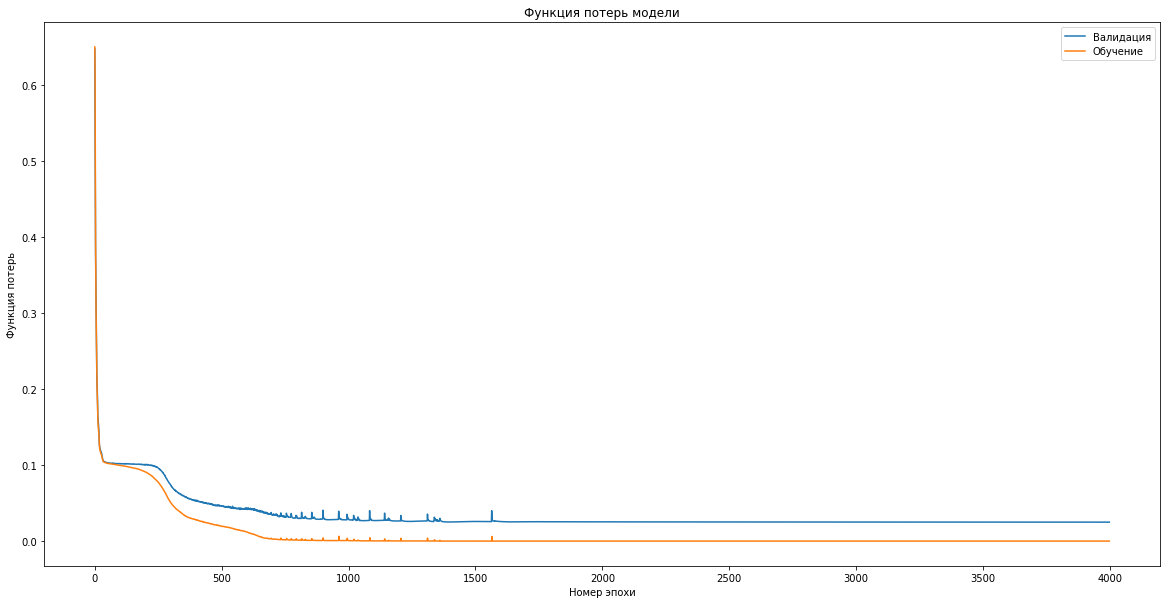

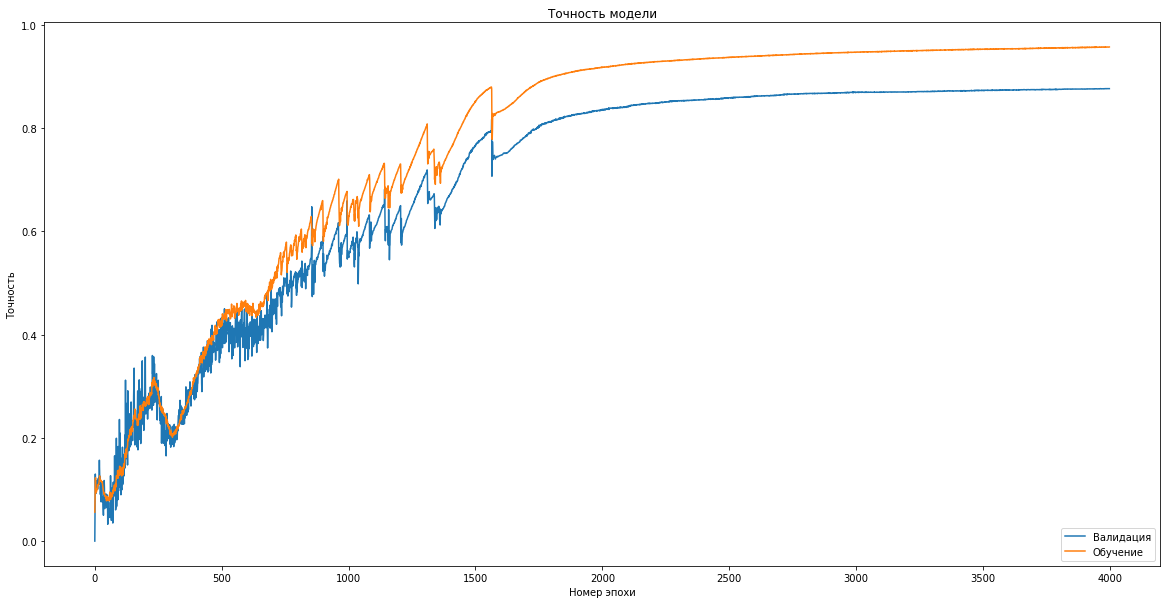

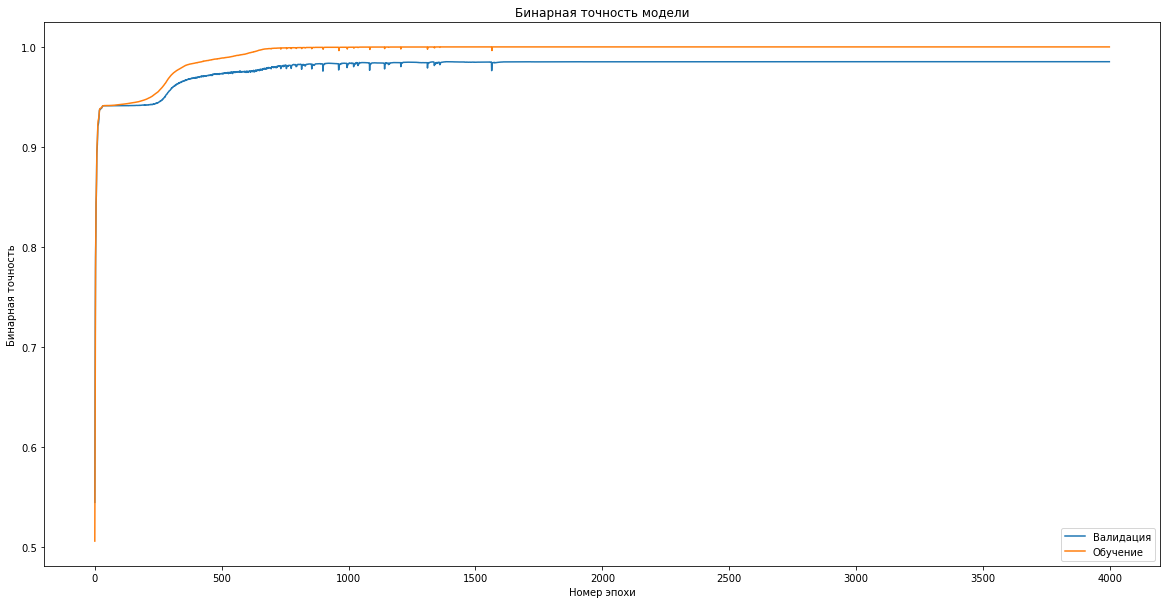

In [39]:
plot_history_fields(history=h, fields=['loss', 'accuracy', 'binary_accuracy'], save=True)

In [ ]:
ac = np.array(h['val_acc'])
ac.argmax(), ac.max()

# Save data

In [ ]:
np.savetxt(model_directory + 'train_data.csv', train_data, delimiter=';')
np.savetxt(model_directory + 'test_data.csv', test_data, delimiter=';')
np.savetxt(model_directory + 'train_labels.csv', train_labels, delimiter=';')
np.savetxt(model_directory + 'test_labels.csv', test_labels, delimiter=';')

In [ ]:
json.dump(h, open(model_directory + 'history.json', 'w'))

In [ ]:
file_name = model_directory + 'last_model.hdf5'

In [ ]:
model.save(file_name)

### Load data from file

In [ ]:
# model = load_model(file_name, custom_objects={'exploss': exploss})

In [38]:
with open(model_directory + 'history.json') as f:
    h = json.load(f)

0. Сделать датасет поменьше
1. Поменять кодирующую матрицу Хэмминга (генерирующую - g.txt) -> Попробовать потренировать
2. Прочитать статью Бернштейна и оттуда перенять архитектуру


1. смотреть насколько маски ошибки отличаются от предикта
2. гиперпараметры (генеративная матрица, количество слоев, что предсказывается)
3. напомнить про ЛСТМ
4. попробовать GRU
5. добавлять 20 ошибо, а не в каждый бит (случайно)
6. генерить не первае 2**16, а рандомные слова